<font size="6">**DSCI100 Group24 Project Report - Predicting Heart Disease**</font>

<br><font size="5">**Introduction:**</font>
<br>
<br>Heart disease is the leading cause of death worldwide, accounting for a significant portion of global mortality. It is a complex condition influenced by numerous factors, including genetics, lifestyle, and environmental aspects. Early detection and prevention of heart disease are crucial for reducing its impact on public health. Some key risk factors associated with heart disease include age, chest pain, and serum cholesterol levels. Heart disease is a serious issue affecting many people worldwide. There are several types of heart disease, including Blood vessel diseases, such as coronary artery disease, Irregular heartbeats, congenital heart defects, disease of the heart muscle, and heart valve disease (Mayo Clinic, 2022).
<br>
<br>In this study, we will explore and predict if a person has heart disease, given their attributes. We will be trying to answer the question: Can we predict the presence of heart disease in individuals using age, chest pain type, and serum cholesterol levels?
<br>
<br>The dataset used in this project contains information on individuals with and without heart disease. It consists of several variables: age, chest pain type, and serum cholesterol in mg/dl. The dataset comprises the following columns:
1. age: The age of the individual in years (numeric).
2. cp: The type of chest pain experienced by the individual, represented as a numerical value <br>(1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic).
3. chol: The individual's serum cholesterol level in mg/dl (numeric).
4. heart_disease: The diagnosis of heart disease (angiographic disease status)<br>(0: indicates the absence of heart disease, >=1: indicates the presence of heart disease).

This dataset will be used to train and test a classification model to predict the presence of heart disease based on the chosen predictors.

<img src="download.jpeg" width = "400"/>
<img src="hd.jpg" width = "400"/>

<br>We will use the following packages to analyze our dataset:

In [91]:
library(tidyverse)
library(tidymodels)
library(repr)
library(digest)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 10)

<font size="5">**Methods:**</font>

We will be setting the seed to 1 to make sure our results are reproducible:

In [92]:
set.seed(1)

<font size="3">**Loading, Wrangling and Cleaning:**</font>

In [93]:
data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names=c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"))

data_mutated <- data |>
  mutate(heart_disease = case_when(num == 0 ~ "absent",
                                   num == 1 ~ "presence",
                                   num == 2 ~ "presence",
                                   num == 3 ~ "presence",
                                   num == 4 ~ "presence")) |> 
  select(-num)

print("Table 1: The Dataset Used in This Data Analysis.")
data_mutated

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1: The Dataset Used in This Data Analysis."


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,absent
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,presence
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,presence
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,absent
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,absent
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,presence
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,presence
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,presence


We have mutated the data so that in the num column, which is the diagnosis of heart disease, 0 will equal no heart disease, and any other number will be changed to equal having heart disease. 

We will use classification to predict whether or not age, chest pain type, cholesterol, and maximum heart rate are predictors of heart disease.


In [94]:
data_clean <- data_mutated |>
  mutate(heart_disease = as.factor(heart_disease)) |>
  select(age,cp,chol,heart_disease) |>
  filter(!is.na(heart_disease))

print("Table 2: The Dataset Used for Data Analysis after Wrangling and Cleaning.")
data_clean

[1] "Table 2: The Dataset Used for Data Analysis after Wrangling and Cleaning."


age,cp,chol,heart_disease
<dbl>,<dbl>,<dbl>,<fct>
63,1,233,absent
67,4,286,presence
67,4,229,presence
37,3,250,absent
41,2,204,absent
⋮,⋮,⋮,⋮
45,1,264,presence
68,4,193,presence
57,4,131,presence


We have cleaned and wrangled the data by selecting the columns we will use for classification. Also, we deleted the observations, which is NA for heart_disease.

<font size="3">**Training and Testing Data:**</font>

Here we are spliting the data into training and testing data sets. We do this to use the training set to “train” the classifier. Then, we can use the classifier to make predictions on new data. We will need to scale the data to ensure all data observations are comparable and contribute equal shares to calculating the distance between points (Tiffany Timbers, 2022). We chose 75% for the training set and 25% for the testing set because it provides a good balance of training the model and evaluating the model.

In [95]:
heart_split <- initial_split(data_clean, prop = 0.75, strata=heart_disease)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

Then, we create two tables (Table 3 and Table 4) show the number of observations in each class, as well as the mean, max, min, sd, median of each predictors.

In [96]:
summary_table_individual <- heart_train |>
  group_by(heart_disease) |>
  summarise(total = n(),
    age_max = max(age, na.rm = TRUE),
    age_min = min(age, na.rm = TRUE),
    age_sd = sd(age, na.rm = TRUE),
    age_n = sum(!is.na(age)),
    age_median = median(age, na.rm = TRUE),
    
    cp_max = max(cp, na.rm = TRUE),
    cp_min = min(cp, na.rm = TRUE),
    cp_sd = sd(cp, na.rm = TRUE),
    cp_n = sum(!is.na(cp)),
    cp_median = median(cp, na.rm = TRUE),
    
    chol_max = max(chol, na.rm = TRUE),
    chol_min = min(chol, na.rm = TRUE),
    chol_sd = sd(chol, na.rm = TRUE),
    chol_n = sum(!is.na(chol)),
    chol_median = median(chol, na.rm = TRUE))

print("Table 3: All Summary Values Grouped by Absent and Presence of Heart Disease.")
summary_table_individual

summary_table_total <- heart_train |>
  summarise(total = n(),
    age_max = max(age, na.rm = TRUE),
    age_min = min(age, na.rm = TRUE),
    age_sd = sd(age, na.rm = TRUE),
    age_n = sum(!is.na(age)),
    age_median = median(age, na.rm = TRUE),
    
    cp_max = max(cp, na.rm = TRUE),
    cp_min = min(cp, na.rm = TRUE),
    cp_sd = sd(cp, na.rm = TRUE),
    cp_n = sum(!is.na(cp)),
    cp_median = median(cp, na.rm = TRUE),
    
    chol_max = max(chol, na.rm = TRUE),
    chol_min = min(chol, na.rm = TRUE),
    chol_sd = sd(chol, na.rm = TRUE),
    chol_n = sum(!is.na(chol)),
    chol_median = median(chol, na.rm = TRUE))

print("Table 4: All Summary Values for Total.")
summary_table_total 

[1] "Table 3: All Summary Values Grouped by Absent and Presence of Heart Disease."


heart_disease,total,age_max,age_min,age_sd,age_n,age_median,cp_max,cp_min,cp_sd,cp_n,cp_median,chol_max,chol_min,chol_sd,chol_n,chol_median
<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
absent,123,76,29,9.805431,123,53,4,1,0.9772161,123,3,417,157,46.16418,123,235
presence,104,77,35,7.713600,104,58,4,1,0.7946329,104,4,407,131,48.29657,104,247


[1] "Table 4: All Summary Values for Total."


total,age_max,age_min,age_sd,age_n,age_median,cp_max,cp_min,cp_sd,cp_n,cp_median,chol_max,chol_min,chol_sd,chol_n,chol_median
<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
227,77,29,9.140635,227,57,4,1,0.9827961,227,3,417,131,47.16515,227,240


The following graph (Figure 1) shows the relationship between the predictors and outcome. As we can see, when a person is experiencing asymptomatic chest pain, it's most likely he has a heart disease presence.

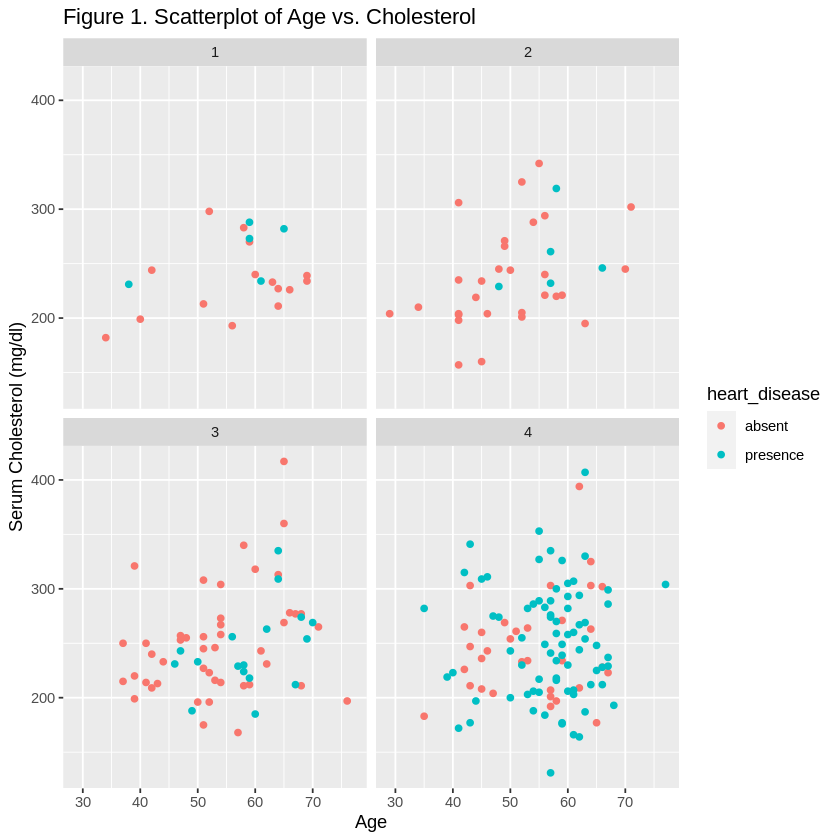

In [97]:
scatter_plot_faceted <- ggplot(heart_train, aes(x = age, y = chol, color = heart_disease)) +
  geom_point() +
  labs(title = "Figure 1. Scatterplot of Age vs. Cholesterol",
       x = "Age",
       y = "Serum Cholesterol (mg/dl)") +
  facet_wrap(~ cp)

scatter_plot_faceted

<font size="3">**Finding K Value:**</font>

We first created a heart_recipe that defines a recipe for predicting heart_disease based on the age, chol, and cp variables. The recipe includes steps to scale and center all predictor variables to make sure they are standardized; this ensures all data observations will be on a comparable scale and contribute equal shares to the calculation of the distance between points. We also created a 5-fold cross-validation object (training_vfold) to perform cross-validation on the training dataset (heart_train). The cross-validation is stratified based on the heart_disease variable to ensure each fold has a similar distribution of heart disease cases. We chose v = 5 because it leads to a faster compuation time.

In [98]:
heart_recipe <- recipe(heart_disease ~ age + chol + cp, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

training_vfold <- vfold_cv(heart_train, v = 5,strata = heart_disease)

Next, we put everything into a workflow to see the number of k-neighbors that give us the best accuracy. We will find the nearest or most similar observations in our training set, which we can use to predict if the patient has heart disease (Tiffany Timbers, 2022). 

In [ ]:
set.seed(1)
knn_spec <- nearest_neighbor(weight_func = "rectangular",neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k = tibble(neighbors = seq(1, 100, 5))


training_workflow <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = training_vfold, grid = k) |>
  collect_metrics()

accuracy <- training_workflow |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean))

print("Table 5. K-neighbors Number Listed by Descending of Mean")
accuracy

cross_val_plot <- accuracy |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", 
       title = "Figure 2. Mean(Accuracy Estimate) vs. Neighbors")

cross_val_plot

best_k = accuracy |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)

<font size="3">**Using Model for Prediction:**</font>
<br>As we can see from both the table and the plot; when k-neighbors equals 26, it gives us the highest mean accuracy which is around 72%. Next we created a k-NN model specification using the best k we found and test it with the testing set.

In [ ]:
best_spec = nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |> 
  set_engine("kknn") |>
  set_mode("classification")

data_best_fit = workflow() |>
  add_recipe(heart_recipe) |>
  add_model(best_spec) |>
  fit(data = heart_train) 

data_prediciton = predict(data_best_fit, heart_test) |>
  bind_cols(heart_test)

print("Table 6. Predictions on The Testing Data, Showing Predicted and Actual Results")
data_prediciton

data_accurcies = data_prediciton |>
  metrics(truth = heart_disease, estimate = .pred_class) |>
  select(.metric, .estimate)

print("Table 7. The Proportion of Accuracy")
data_accurcies

<br>We can also visualize the result with a confusion matrix. The confusion matrix tell us the following: 
<ul>
    <li>True Positives: The number of instances where the model correctly predicted the positive class (e.g., heart disease is present).</li>
    <li>True Negatives: The number of instances where the model correctly predicted the negative class (e.g., heart disease is absent).</li>
    <li>False Positives: The number of instances where the model incorrectly predicted the positive class (i.e., predicted heart disease when it was actually absent).</li>
    <li>False Negatives: The number of instances where the model incorrectly predicted the negative class (i.e., predicted no heart disease when it was actually present).</li>
    </ul>
<br>We can also calculate the accuracy by adding up the sum of true positive and true negatives, then divided by the sum of everything. In this case, (34+22)/(34+13+7+22) = 0.73; which is the same result we get above.

In [ ]:
data_conf_mat = data_prediciton |>
  conf_mat(truth = heart_disease, estimate = .pred_class)

data_conf_mat

<br><font size="3">**Adding New Observations:**</font>
<br>Last, when we pass some new observations to our model, we can predict if the person is diagnosis with heart disease or not. For example:

In [ ]:
new_observation_1 <- tibble(
  age = 55,
  chol = 250,
  cp = 4
)

new_prediction_1 <- predict(data_best_fit, new_observation_1)

print("Table 8. The Predicted Result for The New Observation 1")
new_prediction_1

new_observation_2 <- tibble(
  age = 75,
  chol = 250,
  cp = 4
)

new_prediction_2 <- predict(data_best_fit, new_observation_2)

print("Table 9. The Predicted Result for The New Observation 2")
new_prediction_2

new_observation_3 <- tibble(
  age = 55,
  chol = 450,
  cp = 4
)

new_prediction_3 <- predict(data_best_fit, new_observation_3)

print("Table 10. The Predicted Result for The New Observation 3")
new_prediction_3

new_observation_4 <- tibble(
  age = 55,
  chol = 250,
  cp = 1
)

new_prediction_4 <- predict(data_best_fit, new_observation_4)

print("Table 11. The Predicted Result for The New Observation 4")
new_prediction_4

<font size="5">**Discussion:**</font>
<br>
<br><font size="3">**Summary of finding:**</font>
<br>
<br>Based on the prediction results on the testing set, we found that the results predicted by our predictors, age, chest pain, and serum cholesterol levels, are relatively accurate. From Table 7, we can see that the proportion of accurate prediction results is 73.68%. This is not a low accuracy rate, but it is not enough to prove that all these three variables can be predictors. Figure 1 also leads to this conclusion intuitively. As the chest pain type changes from type 1 to type 4, the number of cyan dots representing the presence of heart disease increases. This shows directly that chest pain type can be used as a predictor. According to the distribution of the dots in Figure 1, we can see that people with heart disease are relatively even regardless of the distribution of different ages and serum cholesterol levels. Therefore, we conclude that there is no significant linear correlation between the presence or absence of heart disease and age change or an individual's serum cholesterol level. Thus, age and individual's serum cholesterol level can not be predictors.

Then, we created some new observations and used our predictive model to predict them. We set the first observation to age 55, a serum cholesterol level of 250 mg/dl, and chest pain type of type 4. The result (Table 8) was that the person had heart disease. Then we changed the three values significantly in the second, third, and fourth observations, respectively. The results (Table 9 and Table 10) did not change when the age and serum cholesterol levels were changed. But the predicted outcome (Table 11) was changed to absent when changing the chest pain type. Therefore, only the chest pain type is suitable for use as a predictor. Age and serum cholesterol levels are not suitable. This is also the reason why the accurate rate is 73% but not higher.

<br><font size="3">**Whether this is what you expected to find?**</font>
<br>
<br>Since the question we need to answer is "Are age, chest pain type and serum cholesterol level can be predictors to predict whether a person has heart disease", then whether the answer is yes or no, they are both the answers to this question and the results we expect. So now we find that among the three variables, only chest pain type can be used as predictors, while the other two cannot. This is the result we expected.

<font size="3">**What impact could such findings have?**</font>
<br>
<br>By doing the same analysis process on different variables, we can find out more variables that have an impact on heart disease. At the same time, we can use comparative analysis to find out which variable has the greatest impact on the risk of heart disease. By differentiating variables, we can target specific regions for treatment.

<br><font size="3">**What future questions could this lead to?**</font>
<br>
<br>Compared to other variables impacting whether to have heart disease, is the chest pain type the most obvious one?

<font size="5">**Reference:**</font>
<br>
<br> Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
<br>
<br>Mayo Foundation for Medical Education and Research. (2022, August 25). Heart disease. Mayo Clinic. Retrieved April 6, 2023, from https://www.mayoclinic.org/diseases-conditions/heart-disease/symptoms-causes/syc-20353118 
<br>
<br>Tiffany Timbers, T. C. (2022, September 24). Data science. Chapter 6 Classification II: evaluation & tuning. Retrieved April 12, 2023, from https://datasciencebook.ca/classification2.html 
<br>
<br>Tiffany Timbers, T. C. (2022, September 24). Data science. Chapter 5 Classification I: training & predicting. Retrieved April 12, 2023, from https://datasciencebook.ca/classification1.html 
